# Features

https://aclanthology.org/2023.bea-1.1.pdf

av syllables per word

n of stopwords

n of nouns

avg word difficulty

n of superlatives

numbers, 2-digit numbers esp., esp. at the beginning of the sentence

"what" the first word

"strong words" like shocking

appearance/count of selected words

n of all caps words

n of words with the first letter capitalized




# Load and process training data

In [3]:
# load dataset and prepare stopwords

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('stopwords')
import re
import string
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from nltk.stem.porter import *

# set pandas options to make it print dfs in a nice format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 200)

# stemmer for stemming words
stemmer = PorterStemmer()

# remove pronouns from stopwords
stop_words = set(stopwords.words('english'))
pronouns = set("i me my you your he she her his him her we us our they them their".split(" "))
stop_words = stop_words.difference(pronouns)
print("i" in stop_words)

data = pd.read_csv("train1.csv")
data.head


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/raisaneh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


False


<bound method NDFrame.head of                                                 headline  clickbait
0                                     Should I Get Bings          1
1          Which TV Female Friend Group Do You Belong In          1
2      The New "Star Wars: The Force Awakens" Trailer...          1
3      This Vine Of New York On "Celebrity Big Brothe...          1
4      A Couple Did A Stunning Photo Shoot With Their...          1
5      How To Flirt With Queer Girls Without Making A...          1
6      32 Cute Things To Distract From Your Awkward T...          1
7                 If Disney Princesses Were From Florida          1
8      What's A Quote Or Lyric That Best Describes Yo...          1
9      Natalie Dormer And Sam Claflin Play A Game To ...          1
10         16 Perfect Responses To The Indian Patriarchy          1
11     21 Times I Died During The "Captain America: C...          1
12     17 Times Kourtney Kardashian Shut Down Her Own...          1
13                

In [4]:
# preprocess: tokenize, stem, remove stopwords

headlines = [word_tokenize(r.lower()) for r in data['headline']]
headlines = [[stemmer.stem(w) for w in h if w not in stop_words and w not in string.punctuation] for h in headlines]



# TF-IDF for significant words
These words are used as features.

In [5]:
# divide dataset into clickbait and news

headlines = pd.Series(headlines,name='headline')
#print(headlines.head)
data['parsed'] = headlines
clickbait = data[data['clickbait'] == 1]
news = data[data['clickbait'] == 0]
clickbait.head

<bound method NDFrame.head of                                                 headline  clickbait                                             parsed
0                                     Should I Get Bings          1                                     [i, get, bing]
1          Which TV Female Friend Group Do You Belong In          1            [tv, femal, friend, group, you, belong]
2      The New "Star Wars: The Force Awakens" Trailer...          1  [new, ``, star, war, forc, awaken, '', trailer...
3      This Vine Of New York On "Celebrity Big Brothe...          1  [vine, new, york, ``, celebr, big, brother, ''...
4      A Couple Did A Stunning Photo Shoot With Their...          1  [coupl, stun, photo, shoot, their, babi, learn...
5      How To Flirt With Queer Girls Without Making A...          1   [flirt, queer, girl, without, make, total, fool]
6      32 Cute Things To Distract From Your Awkward T...          1  [32, cute, thing, distract, your, awkward, tha...
7                 

In [6]:
# turn headline lists into strings for TF_IDF

clickbait_corpus = ""
news_corpus = ""
vocabulary = set()

for l in clickbait['parsed']:
    clickbait_corpus = clickbait_corpus + " ".join(l) + " "
    vocabulary.update(l)
for l in news['parsed']:
    news_corpus = news_corpus + " ".join(l) + " "
    vocabulary.update(l)

print(vocabulary)


{'bet', 'sci-fi', 'gunpoint', 'shirt', '109th', 'performance-enhanc', 'victor', 'priest', 'us-mexico', 'member', 'skid', 'yorker', 'malibu', "'maul", 'inocul', 'pia', 'reschedul', 'usd', 'foie', 'stone', 'marbl', 'd.', 'andalusian', 'audiophil', 'no-show', 'hundr', 'mason', 'bardem', 'e.p.a', 'kenyon', 'wanjiru', 'reoccupi', 'samoy', 'bernardino', 'proctor', 'object', "'do", 'sarcast', 'rivalri', "'concern", '2020', 'bagpip', 'anti-bush', 'flickr', 'cashier', 'madeira', 'lao', 'turban', 'slider', 'judici', 'pre-golden', 'alert', 'monument', 'distinct', 'rohm', 'dream', 'frederick', 'campus', 'l.p.g.a', 'stagecoach', 'rock', 'fifty-star', 'behav', 'slipperi', 'investig', 'kosovo', 'a37', 'co-conspir', 'freeman', "'s", '£5bn', 'palett', 'toast', 'refit', 'canyon', 'eyjafjallajökul', 'furlough', 'skycar', 'whitecap', 'stathi', 'tilman', 'chu', 'petrifi', 'dhillon', '2009', '111', 'wall', 'bleakest', 'outbreak', 'verdict', 'consecut', 'battl', 'store-bought', 'vodka', 'whodunit', 'monserr'

In [7]:
# tf-idf

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

corpus = [clickbait_corpus, news_corpus]
vocabulary = list(vocabulary)

cv = CountVectorizer()
word_count_vector=cv.fit_transform(corpus)

tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

tf_idf_vector = tfidf_transformer.transform(word_count_vector)
feature_names = cv.get_feature_names_out()


#print the scores 
df_click = pd.DataFrame(tf_idf_vector[0].T.todense(), index=feature_names, columns=["tfidf"]) 
df_click = df_click.sort_values(by=["tfidf"],ascending=False)
df_news = pd.DataFrame(tf_idf_vector[1].T.todense(), index=feature_names, columns=["tfidf"]) 
df_news = df_news.sort_values(by=["tfidf"],ascending=False)


In [8]:
print("Highest tf-idf scores, clickbait set:")
df_click.iloc[0:25]

Highest tf-idf scores, clickbait set:


tfidf
you     0.740164
your    0.339353
thing   0.157786
peopl   0.123717
we      0.116502
make    0.115701
know    0.113830
time    0.110089
2015    0.095014
17      0.090316
21      0.086174
actual  0.084304
base    0.081231
19      0.077891
need    0.069073
like    0.068806
way     0.066401
their   0.063195
best    0.063061
new     0.059186
look    0.058518
life    0.056648
ll      0.056114
get     0.051705
re      0.050769

In [9]:
print("Highest tf-idf scores, news set:")
df_news.iloc[0:25]

Highest tf-idf scores, news set:


tfidf
new         0.267709
kill        0.267042
us          0.215034
die         0.145690
win         0.144023
say         0.119352
dead        0.117018
uk          0.103683
presid      0.103350
bomb        0.100683
crash       0.098349
year        0.095015
australian  0.093348
elect       0.092015
first       0.092015
world       0.090348
report      0.089347
obama       0.088681
two         0.087681
state       0.085347
plan        0.083680
polic       0.081013
court       0.080346
china       0.079679
iraq        0.077012

In [10]:
# take the top 25 words with the highest tf-idf scores for neew and clickbait from the earlier lists
significant_words = list(df_news.index[0:50]) + list(df_click.index[0:50])
len(significant_words)

100

#### Notes

I don't think the highest freq terms from the news set are useful features, because they're topic words.

# Model training


In [11]:
# load the data and prepare stopwords

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
nltk.download('stopwords')
import re
import numpy as np
import pandas as pd
import string
from nltk.stem.porter import *
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 200)

stemmer = PorterStemmer()

stop_words = set(stopwords.words('english'))
pronouns = set("i me my you your he she her his him her we us our they them their".split(" "))
stop_words = stop_words.difference(pronouns)
print("i" in stop_words) # should be false


False


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/raisaneh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
"""Use training dataset data"""
data = pd.read_csv("train1.csv")
data = data.sample(frac=1, random_state=1, ignore_index=True)

X_train, X_test, y_train, y_test = train_test_split(data['headline'], data['clickbait'] , test_size=0.2)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(X_train)


(25600,) (25600,) (6400,) (6400,)
4634     Four children among seven killed after police ...
21974                17 Celebrities Only Black People Know
12844    33 Impossibly Cute Ways To Cover Your Body In ...
8339     21 Ridiculous Ways People Have Actually Injure...
16830                     Online purchases boom in Romania
25095    This Couple Remarried Each Other 23 Years Afte...
252      23 Seriously Inspiring Books That'll Help You ...
5055     Sasha Cohen, Lacking an Olympic Gold Medal, Co...
20634    Robert Gates hopes to continue US troop cuts i...
21400    24 Perfectly Romantic Wedding Songs For Twenty...
4566     This Is What $100 A Night Can Get You At Airbn...
1468     This Guy's Cheese Vine Perfectly Sums Up How S...
3871     12 Pictures Of Water Bodies In India That Coul...
11499    This Book Is For Everyone Who Loves TV As Much...
2552       4-Wheel Dreams for Millions of Drivers in India
11016     Try These Tasty Treats For Your Super Bowl Party
7540     Fred Armisen 

## Feature extraction

In [17]:
# turn all headlines into feature vectors

# the feature names are:
feature_names = ['all caps words', "'how to'", "avg. word len", "n of 2-digit numbers", "n of dates", "n of stopwords", "n of nouns", "n of superlatives", "n of adjectives", "n of pronouns", "first word 'what'", "sent len"] + significant_words


def parse(s: str) -> list[str]:
    """Lowercases, tokenizes, stems a string sentence and removes stopwords and punctuation"""
    return [stemmer.stem(w) for w in word_tokenize(s.lower()) if w not in stop_words and w not in string.punctuation]

def get_feature_vector(h: str):
    """Turn a headline into a list of numbers (features)"""
    vec = []
    parsed_h = parse(h)
    # count caps
    caps = len(re.findall(r"((^|\s)[A-Z]+[A-Z]+(\s|$))", h))
    vec.append(caps)

    # count "how to"
    how_to = len(re.findall("how to", h))
    vec.append(how_to)

    # avg word length
    words = h.split(" ")
    avg_w_len = sum([len(w) for w in words]) / len(words)
    vec.append(avg_w_len)

    # 2-digit numbers
    dig = len(re.findall(r"((^|\s)[0-9][0-9](\s|$))", h))
    vec.append(dig)

    # Dates
    dates = len(re.findall(r"(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Nov|Sep|Oct|Dec)\.*\s\d+", h))
    vec.append(dates)

    #stopwords
    words = word_tokenize(h.lower())
    amount_stopwords = sum(word in stop_words for word in words)
    vec.append(amount_stopwords)

    #nouns
    tagged = pos_tag(words)
    noun_tags = ['NN', 'NNS', 'NNP', 'NNPS']
    nouns = sum(1 for word, tag in tagged if tag in noun_tags)
    vec.append(nouns)

    #superlatives
    superlatives = sum(1 for word, tag in tagged if tag in ('JJS', 'RBS'))
    vec.append(superlatives)

    # adjectives
    adjectives = sum(1 for word, tag in tagged if tag in ('JJ', 'JJR'))
    vec.append(adjectives)

    # pronouns
    pronouns = sum(1 for word, tag in tagged if tag in ('PRP', 'PRP$'))
    vec.append(pronouns)

    # first word "what"
    vec.append(1 if parsed_h[0] == "what" else 0)

    # len
    vec.append(len(h.split(" ")))

    # count word occurrences
    for word in significant_words:
        vec.append(parsed_h.count(word))
    
    return pd.Series(vec, index=feature_names)


X_train_p = []
# create feature vec
for headline in X_train:
    X_train_p.append(get_feature_vector(headline))

X_test_p = []
# create feature vec
for headline in X_test:
    X_test_p.append(get_feature_vector(headline))


In [18]:
len(X_train_p)
print("Length of one feature vector: ", X_train_p[0].shape)

Length of one feature vector:  (112,)


# Algorithm comparison

Compare Naive Bayes, SVM, LogReg and K-Nearest Neighbours algorithms on test data and perform a Wald test to see which performs the best on our data and features.

In [ ]:
# Naive Bayes model
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

y_pred_GNB = gnb.fit(X_train_p, y_train).predict(X_test_p)

print("Number of mislabeled points out of a total %d points: %d. Accuracy:"

      % (X_test.shape[0], (y_test != y_pred_GNB).sum()))
(y_test == y_pred_GNB).sum()/y_test.shape[0]

Number of mislabeled points out of a total 6400 points: 807. Accuracy:


0.87390625

In [ ]:
# support vector machines
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train_p, y_train)

y_pred_SVM = clf.predict(X_test_p)

print("Number of mislabeled points out of a total %d points: %d. Accuracy: "

      % (X_test.shape[0], (y_test != y_pred_SVM).sum()))
(y_test == y_pred_SVM).sum()/y_test.shape[0]

Number of mislabeled points out of a total 6400 points: 685. Accuracy: 


0.89296875

In [19]:
# logistic regression
from sklearn.linear_model import LogisticRegression

def decision(x):
    """Make the classification decision"""
    prob_news = x[0]
    prob_click = x[1]
    if (prob_news >= 0.5) and (prob_click >= 0.5):
        return np.NAN
    if (prob_news < 0.5) and (prob_click < 0.5):
        return np.NAN
    if (prob_news >= 0.5) and (prob_click < 0.5):
        return 0
    if (prob_news < 0.5) and (prob_click >= 0.5):
        return 1

logReg = LogisticRegression(random_state=1, multi_class='ovr', max_iter=200)
logReg.fit(X_train_p, y_train)

print(logReg.classes_)

y_pred_LR = logReg.predict_proba(X_test_p)

y_pred =[decision(x) for x in y_pred_LR]
y_pred_LR2 = np.array(y_pred)

print("Number of mislabeled points out of a total %d points: %d. Accuracy: %f \n"

      % (X_test.shape[0], (y_test != y_pred).sum(), (y_test == y_pred).sum()/y_test.shape[0]))

print("Number of no decisions: ", np.isnan(y_pred_LR2).sum(), "\n")

for x,y,z in zip(X_test[(y_test != y_pred)], y_pred_LR2[(y_test != y_pred)],y_test[(y_test != y_pred)]):
    print(x,y, "actual:",z)
    print([(i,x1) for i,x1 in get_feature_vector(x).items() if x1!=0 ], "\n")


/home/raisaneh/anaconda3/envs/compsemenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/raisaneh/anaconda3/envs/compsemenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[0 1]
Number of mislabeled points out of a total 6400 points: 592. Accuracy: 0.907500 

Number of no decisions:  0 

John Stamos And Julianne Moore Acted Out A Soap Opera Entirely Using Taylor Swift Lyrics 0 actual: 1
[('avg. word len', 4.933333333333334), ('n of stopwords', 3.0), ('n of nouns', 8.0), ('sent len', 15.0)] 

Zendaya Coleman Is Officially The Newest CoverGirl 0 actual: 1
[('avg. word len', 6.285714285714286), ('n of stopwords', 2.0), ('n of nouns', 3.0), ('n of superlatives', 1.0), ('sent len', 7.0)] 

Two Huge Broadway Stars Covered Selena Gomez And It's Amazing 0 actual: 1
[('avg. word len', 5.2), ('n of stopwords', 2.0), ('n of nouns', 3.0), ('n of adjectives', 3.0), ('n of pronouns', 1.0), ('sent len', 10.0), ('two', 1.0)] 

Medtronic Paid Dr. Kuklo for While He Was Still in Army 1 actual: 0
[('avg. word len', 4.090909090909091), ('n of stopwords', 4.0), ('n of nouns', 4.0), ('n of pronouns', 1.0), ('sent len', 11.0)] 

Two Truths And A Lie: Ed Sheeran And Jamie Lawso

In [ ]:
# k-nearest neighbors

from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=9)

neigh.fit(np.array(X_train_p), y_train)

y_pred_n = neigh.predict(np.array(X_test_p))

print("Number of mislabeled points out of a total %d points: %d. Accuracy: "

      % (X_test.shape[0], (y_test != y_pred_n).sum()))
(y_test == y_pred_n).sum()/y_test.shape[0]

Number of mislabeled points out of a total 6400 points: 819. Accuracy: 


0.87203125

## Compare the algorithm accuracy with Wald test

The data for each algorithm is Binomial(6400, x) where x is the true error rate (mean) of the algorithm. The accuracy rate is \\hat{x}, so the sample mean or sample error rate

The test set is the same for all, so perform paired Wald tests.

In [ ]:
# perform wald test with p-value to compare the different algorithms to see which is the best if any

"""
Sample accuracies:

GNBayes:   x_1 = 0.87484375

SVM:       x_2 = 0.90109375

LogReg:    x_3 = 0.909687 

Neighbors: x_4 = 0.8765625



H_0: x_i - x_j = 0 

Hypothesis: the real accuracy is the same. If there is evidence against the hypothesis, it means that
the real accuracies are different, and the one with the larger sample accuracy probably has a higher
real accuracy.

"""
import math
from scipy.stats import norm

test_set_size = len(y_test)


# create the error vector for the predicitions, 1=correct, 0=incorrect
# Alg 1
y_pred_GNB_err = np.array([1 if y_pred_GNB[i] == y_test.iloc[i] else 0 for i in range(test_set_size)])
# Alg 2
y_pred_SVM_err = np.array([1 if y_pred_SVM[i] == y_test.iloc[i] else 0 for i in range(test_set_size)])
# Alg 3
y_pred_LR_err = np.array([1 if y_pred_LR2[i] == y_test.iloc[i] else 0 for i in range(test_set_size)])
# Alg 4
y_pred_neigh_err = np.array([1 if y_pred_n[i] == y_test.iloc[i] else 0 for i in range(test_set_size)])


#_________________________________________________________________________________________________________-
# GNBayes vs SVM

# error difference
D_12 = y_pred_GNB_err - y_pred_SVM_err
# difference in error rate 
delta_12 = sum(D_12) / test_set_size

# sample variance
S2 = sum([(x-delta_12)**2 for x in D_12]) / test_set_size

# standard error
se_12 = math.sqrt(S2) / math.sqrt(test_set_size)

# Wald statistic
W_12 = delta_12 / se_12

p_value = 2 * norm.cdf(-abs(W_12))

print(p_value)
print("It seems SVM is better than GNB\n")


# GNBayes vs LogReg

# error difference
D_13 = y_pred_GNB_err - y_pred_LR_err
# difference in error rate 
delta_13 = sum(D_13) / test_set_size

# sample variance
S2 = sum([(x-delta_13)**2 for x in D_13]) / test_set_size

# standard error
se_13 = math.sqrt(S2) / math.sqrt(test_set_size)

# Wald statistic
W_13 = delta_13 / se_13

p_value = 2 * norm.cdf(-abs(W_13))

print(p_value) #0.00000000000002277332
print("It seems LogReg is much better than GNB\n")

# GNBayes vs Neighbors

D_14 = y_pred_GNB_err - y_pred_neigh_err
delta_14 = sum(D_14) / test_set_size

S2 = sum([(x-delta_14)**2 for x in D_14]) / test_set_size

se_14 = math.sqrt(S2) / math.sqrt(test_set_size)

W_14 = delta_14 / se_14

p_value = 2 * norm.cdf(-abs(W_14))

print(p_value) 
print("There's no evidence that k-nearest neighbours performs better than GNB\n")

# SVM vs LogReg

D_23 = y_pred_SVM_err - y_pred_LR_err
delta_23 = sum(D_23) / test_set_size

S2 = sum([(x-delta_23)**2 for x in D_23]) / test_set_size

se_23 = math.sqrt(S2) / math.sqrt(test_set_size)

W_23 = delta_23 / se_23

p_value = 2 * norm.cdf(-abs(W_23))

print(p_value) 
print("It seems that LogReg performs better than SVM\n")

# SVM vs Neighbors

D_24 = y_pred_SVM_err - y_pred_neigh_err
delta_24 = sum(D_24) / test_set_size

S2 = sum([(x-delta_24)**2 for x in D_24]) / test_set_size

se_24 = math.sqrt(S2) / math.sqrt(test_set_size)

W_24 = delta_24 / se_24

p_value = 2 * norm.cdf(-abs(W_24))

print(p_value)
print("There is evidence that SVM performs better than Neighbors at accuracy \n")

# LogReg vs Neighbors

D_34 = y_pred_LR_err - y_pred_neigh_err
delta_34 = sum(D_34) / test_set_size

S2 = sum([(x-delta_34)**2 for x in D_34]) / test_set_size

se_34 = math.sqrt(S2) / math.sqrt(test_set_size)

W_34 = delta_34 / se_34

p_value = 2 * norm.cdf(-abs(W_34))

print(p_value) 
print("It seems LogReg is much better than Neighbors\n")


1.578880293222859e-10
It seems SVM is better than GNB

1.8635444813935673e-22
It seems LogReg is much better than GNB

0.7170037939009227
There's no evidence that k-nearest neighbours performs better than GNB

0.00024205372252976903
It seems that LogReg performs better than SVM

6.60286291791173e-13
There is evidence that SVM performs better than Neighbors at accuracy 

3.0518424864994334e-19
It seems LogReg is much better than Neighbors



GNBayes:   x_1 = 0.87484375

SVM:       x_2 = 0.90109375

LogReg:    x_3 = 0.909687 

Neighbors: x_4 = 0.8765625

- GNBayes vs SVM: SVM wins

- GNBayes vs LogReg: LogReg wins

- GNBayes vs Neigh: tie

- SVM vs LogReg: SVM

- SVM vs Neigh: SVM wins

- Logreg vs Neigh: LogReg wins

## Result

Logistic regression should be the best for the task.

# Model analysis

Analyse what the model does

In [163]:
# most significant features based on coefficient magnitude
# positive: associated with clickbait
# negative: associated with news

from math import exp

cf = [(f,c) for (c,f) in zip(logReg.coef_[0], feature_names)]
cf = sorted(cf, key=lambda x: x[1], reverse=True)

for x in cf:
    print(x)

('you', 4.0638121497955275)
('charact', 3.8939986826589137)
('hilari', 3.881195981321467)
('everyon', 3.6807496992404913)
('2015', 3.5536518551950453)
('love', 3.1046973922047947)
('actual', 3.015997673776589)
('everi', 2.8192658906901555)
('your', 2.78160315420179)
('thing', 2.740081730659148)
('n of 2-digit numbers', 2.608666961980753)
('tweet', 2.543200347325487)
('guess', 2.505200148770644)
('peopl', 2.3674054649340293)
('we', 2.3203595159279917)
('photo', 2.0774126783611444)
('girl', 2.0556759853438806)
('real', 1.8464206642529672)
('movi', 1.8151444604489233)
('tri', 1.8113870683794175)
('her', 1.592678101582856)
('best', 1.5852801645080403)
('ever', 1.562240008213704)
('pictur', 1.5499205825620939)
('21', 1.520420638544036)
('17', 1.507811536048017)
('like', 1.4251339809204588)
('look', 1.4193267787597574)
('zodiac', 1.1635370786668908)
('23', 1.1232426683577725)
('n of pronouns', 1.1164953333438434)
('19', 1.094045955304973)
('time', 1.057758990726196)
('life', 1.00404438783806

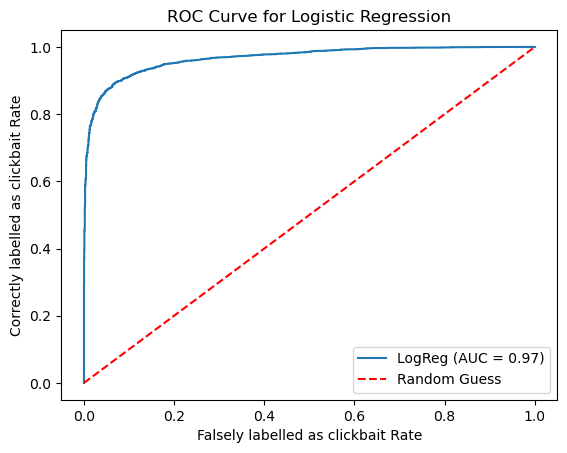

In [162]:
# roc curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, [x[1] for x in y_pred_LR], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'LogReg (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

plt.xlabel('Falsely labelled as clickbait Rate')
plt.ylabel('Correctly labelled as clickbait Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend()
plt.show()

### What the ROC curve tells us

The perfect classifier would have a true positive rate of 1 and false positive rate of 0. Our model performs well: it's able to achieve a near-zero false positive rate at true positive rates of ~0.8. At FP=0.5, the TP rate is well over 0.9. But the precision of our model might not be so good, and it might be overfitting to training data.

In [ ]:
# confusion matrix
# TODO
import scikitpl

skplt.metrics.plot_confusion_matrix(y_test, y_gbc_pred, normalize=False, title = 'Confusion Matrix for GBC')

# The Model

Use the previously fitted Logistic Regression model on real data

In [20]:
"""Use cnn dataset"""
data = pd.read_csv("data/cnn.csv")

feature_vectors = []
for i,headline in data.iterrows():
    feature_vectors.append(get_feature_vector(headline[0]))

predictions = logReg.predict(feature_vectors)
classified = pd.Series(predictions)

classified_data = pd.concat([data,classified], axis=1)
#print(classified_data)

print("Number of clickbait %d, news %d out of a total %d points. N of no decision %d \n Clickbait amount: %f"

      % ((classified == 1).sum(), (classified == 0).sum(), data.shape[0], np.isnan(classified).sum(), (classified == 1).sum()/data.shape[0]))


classified_data.to_csv("classified/cnn_classified.csv",sep=",", na_rep="NA", index=False)


/tmp/ipykernel_1713397/4124148676.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  feature_vectors.append(get_feature_vector(headline[0]))


Number of clickbait 1752, news 2769 out of a total 4521 points. N of no decision 0 
 Clickbait amount: 0.387525


In [21]:
"""Classify apn news data"""
data = pd.read_csv("data/apn_news.csv")

feature_vectors = []
for i,headline in data.iterrows():
    feature_vectors.append(get_feature_vector(headline[0]))

predictions = logReg.predict(feature_vectors)
classified = pd.Series(predictions)

classified_data = pd.concat([data,classified], axis=1)
#print(classified_data)

print("Number of clickbait %d, news %d out of a total %d points. N of no decision %d \n Clickbait amount: %f"

      % ((classified == 1).sum(), (classified == 0).sum(), data.shape[0], np.isnan(classified).sum(), (classified == 1).sum()/data.shape[0]))


classified_data.to_csv("classified/apn_classified.csv",sep=",", na_rep="NA", index=False)


/tmp/ipykernel_1713397/920955636.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  feature_vectors.append(get_feature_vector(headline[0]))


Number of clickbait 1754, news 4107 out of a total 5861 points. N of no decision 0 
 Clickbait amount: 0.299266


In [ ]:
"""Use npr dataset"""
data = pd.read_csv("data/npr_news.csv")

feature_vectors = []
for i,headline in data.iterrows():
    feature_vectors.append(get_feature_vector(headline[0]))

predictions = logReg.predict(feature_vectors)
classified = pd.Series(predictions)

classified_data = pd.concat([data,classified], axis=1)
#print(classified_data)

print("Number of clickbait %d, news %d out of a total %d points. N of no decision %d \n Clickbait amount: %f"

      % ((classified == 1).sum(), (classified == 0).sum(), data.shape[0], np.isnan(classified).sum(), (classified == 1).sum()/data.shape[0]))


classified_data.to_csv("classified/npr_classified.csv",sep=",", na_rep="NA", index=False)


/tmp/ipykernel_1393995/752530611.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  feature_vectors.append(get_feature_vector(headline[0]))


Number of clickbait 605, news 1100 out of a total 1705 points. N of no decision 0 
 Clickbait amount: 0.354839


In [23]:
"""Use buzzfeed dataset"""
data = pd.read_csv("data/buzzfeed.csv")

feature_vectors = []
for i,headline in data.iterrows():
    feature_vectors.append(get_feature_vector(headline[0]))

predictions = logReg.predict(feature_vectors)
classified = pd.Series(predictions)

classified_data = pd.concat([data,classified], axis=1)
#print(classified_data)

print("Number of clickbait %d, news %d out of a total %d points. N of no decision %d \n Clickbait amount: %f"

      % ((classified == 1).sum(), (classified == 0).sum(), data.shape[0], np.isnan(classified).sum(), (classified == 1).sum()/data.shape[0]))


classified_data.to_csv("classified/buzzfeed_classified.csv",sep=",", na_rep="NA", index=False)


/tmp/ipykernel_1713397/2164326510.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  feature_vectors.append(get_feature_vector(headline[0]))


Number of clickbait 344, news 16 out of a total 360 points. N of no decision 0 
 Clickbait amount: 0.955556


In [24]:
"""Use BBC dataset"""
data = pd.read_csv("data/bbc.csv")

feature_vectors = []
for i,headline in data.iterrows():
    feature_vectors.append(get_feature_vector(headline[0]))

predictions = logReg.predict(feature_vectors)
classified = pd.Series(predictions)

classified_data = pd.concat([data,classified], axis=1)
#print(classified_data)

print("Number of clickbait %d, news %d out of a total %d points. N of no decision %d \n Clickbait amount: %f"

      % ((classified == 1).sum(), (classified == 0).sum(), data.shape[0], np.isnan(classified).sum(), (classified == 1).sum()/data.shape[0]))


classified_data.to_csv("classified/bbc_classified.csv",sep=",", na_rep="NA", index=False)


/tmp/ipykernel_1713397/3099622849.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  feature_vectors.append(get_feature_vector(headline[0]))


Number of clickbait 477, news 2018 out of a total 2495 points. N of no decision 0 
 Clickbait amount: 0.191182
